In [1]:
import detector
import importlib
import data_loader
import pandas as pd
import unet_detector
import seaborn as sn
import matplotlib.pyplot as plt

importlib.reload(detector)
importlib.reload(unet_detector)
importlib.reload(data_loader)

%matplotlib inline

In [2]:
detector = unet_detector.UNetDetector()

In [3]:
dataset_loader = data_loader.CarDamageDatasetLoader()

train_ds, eval_ds, train_df, eval_df = dataset_loader.load_dataset()
print("Training Dataset Length: " + str(len(train_df)))
print("Evaluation Dataset Length: " + str(len(eval_df)))
print("\nSample Training Dataset:")
display(train_df[:2])

Training Dataset Length: 90
Evaluation Dataset Length: 10

Sample Training Dataset:


,id,image,label
0,/Users/akash/Code/car_images/dataset/fake/niss...,<PIL.Image.Image image mode=RGB size=224x224 a...,Fake
1,/Users/akash/Code/car_images/dataset/fake/niss...,<PIL.Image.Image image mode=RGB size=224x224 a...,Fake


Fake samples


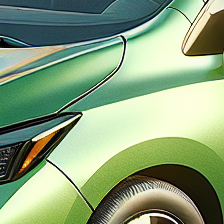

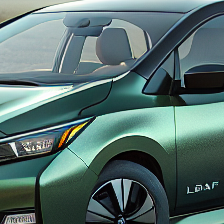

In [4]:
print("Fake samples")
for image in train_df[( train_df["label"] == "Fake")].iloc[:min(2, len(train_df))]["image"]:
    display(image)

Real samples


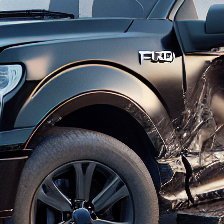

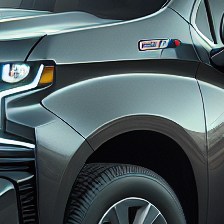

In [5]:
print("Real samples")
for image in train_df[( train_df["label"] == "Real")].iloc[:min(2, len(train_df))]["image"]:
    display(image)

In [6]:
model = detector.get_model()
model

UNetClassifier(
  (enc1): UNetBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc2): UNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc3): UNetBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [7]:
trained_model = detector.train_model(model, train_ds, eval_ds, 2, 16)

Using device: mps


Epoch 1/2 (Eval):   0%|          | 0/1 [00:00<?, ?it/s]/opt/miniconda3/envs/car_images/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Epoch 1/2 (Eval): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



Epoch 1/2 Summary:
Train Loss: 0.6634
Eval Loss: 0.7042
Train Metrics: {'accuracy': np.float64(0.6), 'precision': np.float64(0.6443395146520147), 'recall': np.float64(0.6), 'bad_predictions': np.float64(6.0)}
Eval Metrics: {'accuracy': np.float64(0.5), 'precision': np.float64(0.25), 'recall': np.float64(0.5), 'bad_predictions': np.float64(5.0)}


Epoch 2/2 (Eval):   0%|          | 0/1 [00:00<?, ?it/s]/opt/miniconda3/envs/car_images/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Epoch 2/2 (Eval): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


Epoch 2/2 Summary:
Train Loss: 0.3504
Eval Loss: 0.7436
Train Metrics: {'accuracy': np.float64(0.9041666666666667), 'precision': np.float64(0.908234126984127), 'recall': np.float64(0.9041666666666667), 'bad_predictions': np.float64(1.3333333333333333)}
Eval Metrics: {'accuracy': np.float64(0.5), 'precision': np.float64(0.25), 'recall': np.float64(0.5), 'bad_predictions': np.float64(5.0)}


Accuracy:		50.00
Bad Predictions:	0/10
{}


/Users/akash/Code/car_images/detector.py:31: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp+fn)


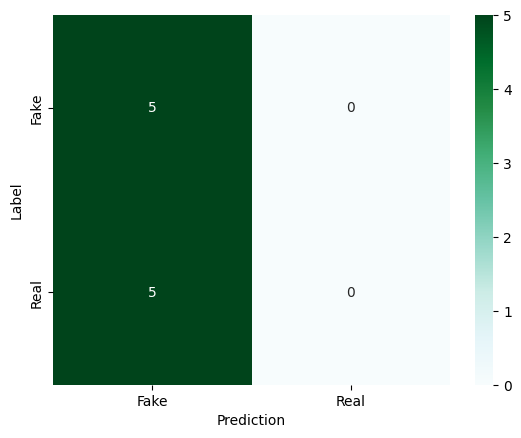

,Fake,Real
Fake,5,0
Real,5,0


,label,precision,recall
0,Real,0.0,NaN
1,Fake,1.0,0.5


In [8]:
y_true, y_pred, images, df_cm, df_metrics, accuracy, bad_prediction_count, bad_predictions = detector.evaluate_model(model, eval_ds)
df_results = pd.DataFrame(zip(y_true, y_pred, images), columns=["Label", "Prediction", "Image"])

print(f"Accuracy:\t\t{accuracy:.2f}")
print(f"Bad Predictions:\t{bad_prediction_count}/{len(y_true)}")
print(bad_predictions)

plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()
display(df_cm)

display(df_metrics)

In [9]:
def display_sample_failures(df, label, prediction):
    images = df[(df["Label"] == label) & (df["Prediction"] == prediction)]["Image"]
    print(f"Found {len(images)} samples with label '{label}' and prediction '{prediction}'")

    for i in range(min(5, len(images))):
        display(images.iloc[i])


display_sample_failures(df_results, label="Fake", prediction="Real")

Found 0 samples with label 'Fake' and prediction 'Real'
